Proyecto Mineria de Datos (IIC2433):
### Minería de Datos para Equidad Educativa en Comunas Vulnerables
##### Grupo: 14

##### Integrantes:
1) Ignacio Gabler  
2) Cristóbal Merino


In [32]:
import zipfile
import os
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from umap import UMAP

### 1) Preprocesamiento de Datos

In [19]:
# Obtener la ruta del directorio actual
ruta_actual = pathlib.Path().absolute()

# Ruta relativa al archivo zip
ruta_zip = os.path.join(ruta_actual, "archive.zip")
# Carpeta destino
carpeta_destino = os.path.join(ruta_actual, "datos")

# Descomprimir
with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
    zip_ref.extractall(carpeta_destino)

print(f"archivos extraidos en: {carpeta_destino}")

archivos extraidos en: c:\Users\cmeri\OneDrive - Universidad Católica de Chile\Universidad\2025-1\IIC2433\md14_proyecto\datos


In [20]:
df = pd.read_csv("datos/Expanded_data_with_more_features.csv", index_col=0)
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30641 entries, 0 to 960
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               30641 non-null  object 
 1   EthnicGroup          28801 non-null  object 
 2   ParentEduc           28796 non-null  object 
 3   LunchType            30641 non-null  object 
 4   TestPrep             28811 non-null  object 
 5   ParentMaritalStatus  29451 non-null  object 
 6   PracticeSport        30010 non-null  object 
 7   IsFirstChild         29737 non-null  object 
 8   NrSiblings           29069 non-null  float64
 9   TransportMeans       27507 non-null  object 
 10  WklyStudyHours       29686 non-null  object 
 11  MathScore            30641 non-null  int64  
 12  ReadingScore         30641 non-null  int64  
 13  WritingScore         30641 non-null  int64  
dtypes: float64(1), int64(3), object(10)
memory usage: 3.5+ MB


In [22]:
df.isnull().sum()

Gender                    0
EthnicGroup            1840
ParentEduc             1845
LunchType                 0
TestPrep               1830
ParentMaritalStatus    1190
PracticeSport           631
IsFirstChild            904
NrSiblings             1572
TransportMeans         3134
WklyStudyHours          955
MathScore                 0
ReadingScore              0
WritingScore              0
dtype: int64

In [23]:
df_copy = df.copy()
df_copy = df_copy.dropna()

print(f"Filas antes de eliminar nulos: {len(df)}")
print(f"Filas después de eliminar nulos: {len(df_copy)}")

Filas antes de eliminar nulos: 30641
Filas después de eliminar nulos: 19243


### 2) Encoding variables categoricas

#### Label encoding

In [24]:
df_copy['Gender'] = df_copy['Gender'].map({'female': 0, 'male': 1})
df_copy['IsFirstChild'] = df_copy['IsFirstChild'].map({'no': 0, 'yes': 1})
df_copy['TestPrep'] = df_copy['TestPrep'].map({'none': 0, 'completed': 1})

#### One hot encoding

In [25]:
df_copy = pd.get_dummies(df_copy, columns=['EthnicGroup', 'PracticeSport', 'ParentEduc', 'LunchType', 'ParentMaritalStatus', 'TransportMeans', 'WklyStudyHours'], drop_first=True)

In [26]:
df_copy = df_copy.astype(int)

df_copy.head(1)

print("Nombres de columnas:")
print(df_copy.columns.tolist())

Nombres de columnas:
['Gender', 'TestPrep', 'IsFirstChild', 'NrSiblings', 'MathScore', 'ReadingScore', 'WritingScore', 'EthnicGroup_group B', 'EthnicGroup_group C', 'EthnicGroup_group D', 'EthnicGroup_group E', 'PracticeSport_regularly', 'PracticeSport_sometimes', "ParentEduc_bachelor's degree", 'ParentEduc_high school', "ParentEduc_master's degree", 'ParentEduc_some college', 'ParentEduc_some high school', 'LunchType_standard', 'ParentMaritalStatus_married', 'ParentMaritalStatus_single', 'ParentMaritalStatus_widowed', 'TransportMeans_school_bus', 'WklyStudyHours_< 5', 'WklyStudyHours_> 10']


In [27]:
df_copy.head()

,Gender,TestPrep,IsFirstChild,NrSiblings,MathScore,ReadingScore,WritingScore,EthnicGroup_group B,EthnicGroup_group C,EthnicGroup_group D,...,ParentEduc_master's degree,ParentEduc_some college,ParentEduc_some high school,LunchType_standard,ParentMaritalStatus_married,ParentMaritalStatus_single,ParentMaritalStatus_widowed,TransportMeans_school_bus,WklyStudyHours_< 5,WklyStudyHours_> 10
2,0,0,1,4,87,93,91,1,0,0,...,1,0,0,1,0,1,0,1,1,0
4,1,0,1,0,76,78,75,0,1,0,...,0,1,0,1,1,0,0,1,0,0
5,0,0,1,1,73,84,79,1,0,0,...,0,0,0,1,1,0,0,1,0,0
6,0,1,0,1,85,93,89,1,0,0,...,0,1,0,1,0,0,1,0,0,0
7,1,0,1,1,41,43,39,1,0,0,...,0,1,0,0,1,0,0,0,0,1


#### Variables Objetivo

In [28]:
y = df_copy[['MathScore', 'ReadingScore', 'WritingScore']]
X = df_copy.drop(columns=['MathScore', 'ReadingScore', 'WritingScore'])

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=df_copy.drop(columns=['MathScore', 'ReadingScore', 'WritingScore']).columns)

In [29]:
X.head()

,Gender,TestPrep,IsFirstChild,NrSiblings,EthnicGroup_group B,EthnicGroup_group C,EthnicGroup_group D,EthnicGroup_group E,PracticeSport_regularly,PracticeSport_sometimes,...,ParentEduc_master's degree,ParentEduc_some college,ParentEduc_some high school,LunchType_standard,ParentMaritalStatus_married,ParentMaritalStatus_single,ParentMaritalStatus_widowed,TransportMeans_school_bus,WklyStudyHours_< 5,WklyStudyHours_> 10
0,-0.984171,-0.727186,0.741438,1.283176,1.978686,-0.687899,-0.590093,-0.405038,-0.751906,0.990329,...,3.647885,-0.546464,-0.484472,0.736815,-1.156295,1.782133,-0.140017,0.840202,1.605024,-0.460191
1,1.016083,-0.727186,0.741438,-1.487488,-0.505386,1.453702,-0.590093,-0.405038,-0.751906,0.990329,...,-0.274131,1.829946,-0.484472,0.736815,0.864831,-0.561125,-0.140017,0.840202,-0.623044,-0.460191
2,-0.984171,-0.727186,0.741438,-0.794822,1.978686,-0.687899,-0.590093,-0.405038,1.329954,-1.009765,...,-0.274131,-0.546464,-0.484472,0.736815,0.864831,-0.561125,-0.140017,0.840202,-0.623044,-0.460191
3,-0.984171,1.375164,-1.348731,-0.794822,1.978686,-0.687899,-0.590093,-0.405038,-0.751906,-1.009765,...,-0.274131,1.829946,-0.484472,0.736815,-1.156295,-0.561125,7.141996,-1.190190,-0.623044,-0.460191
4,1.016083,-0.727186,0.741438,-0.794822,1.978686,-0.687899,-0.590093,-0.405038,-0.751906,0.990329,...,-0.274131,1.829946,-0.484472,-1.357193,0.864831,-0.561125,-0.140017,-1.190190,-0.623044,2.173010


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_math = KNeighborsRegressor(n_neighbors=5)
knn_math.fit(X_train, y_train['MathScore'])

y_pred_math = knn_math.predict(X_test)
mse_math = mean_squared_error(y_test['MathScore'], y_pred_math)
print(f"MSE para MathScore: {mse_math:.2f}")

knn_reading = KNeighborsRegressor(n_neighbors=5)
knn_reading.fit(X_train, y_train['ReadingScore'])
y_pred_reading = knn_reading.predict(X_test)
mse_reading = mean_squared_error(y_test['ReadingScore'], y_pred_reading)
print(f"MSE para ReadingScore: {mse_reading:.2f}")

knn_writing = KNeighborsRegressor(n_neighbors=5)
knn_writing.fit(X_train, y_train['WritingScore'])
y_pred_writing = knn_writing.predict(X_test)
mse_writing = mean_squared_error(y_test['WritingScore'], y_pred_writing)
print(f"MSE para WritingScore: {mse_writing:.2f}")

MSE para MathScore: 208.21
MSE para ReadingScore: 206.10
MSE para WritingScore: 200.52


Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.68      0.72      0.70      2261
        True       0.56      0.51      0.53      1588

    accuracy                           0.63      3849
   macro avg       0.62      0.61      0.62      3849
weighted avg       0.63      0.63      0.63      3849



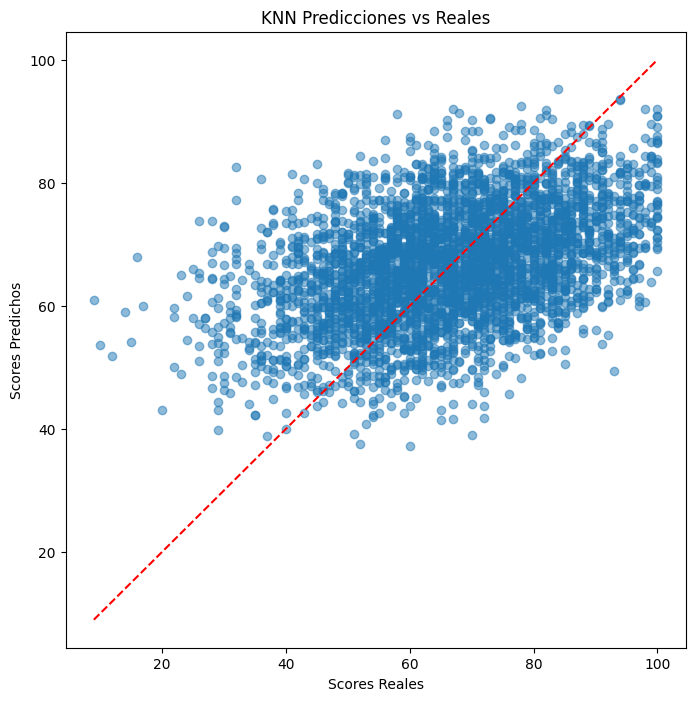

In [39]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train['MathScore'] > 70)
y_pred_class = knn_classifier.predict(X_test)

print("Reporte de clasificación:")
print(classification_report(y_test['MathScore'] > 70, y_pred_class))

plt.figure(figsize=(8, 8))
plt.scatter(y_test['MathScore'], y_pred_math, alpha=0.5, label='MathScore')
plt.plot([y_test['MathScore'].min(), y_test['MathScore'].max()], [y_test['MathScore'].min(), y_test['MathScore'].max()], color='red', linestyle='--')
plt.xlabel('Scores Reales')
plt.ylabel('Scores Predichos')
plt.title('KNN Predicciones vs Reales')
plt.show()

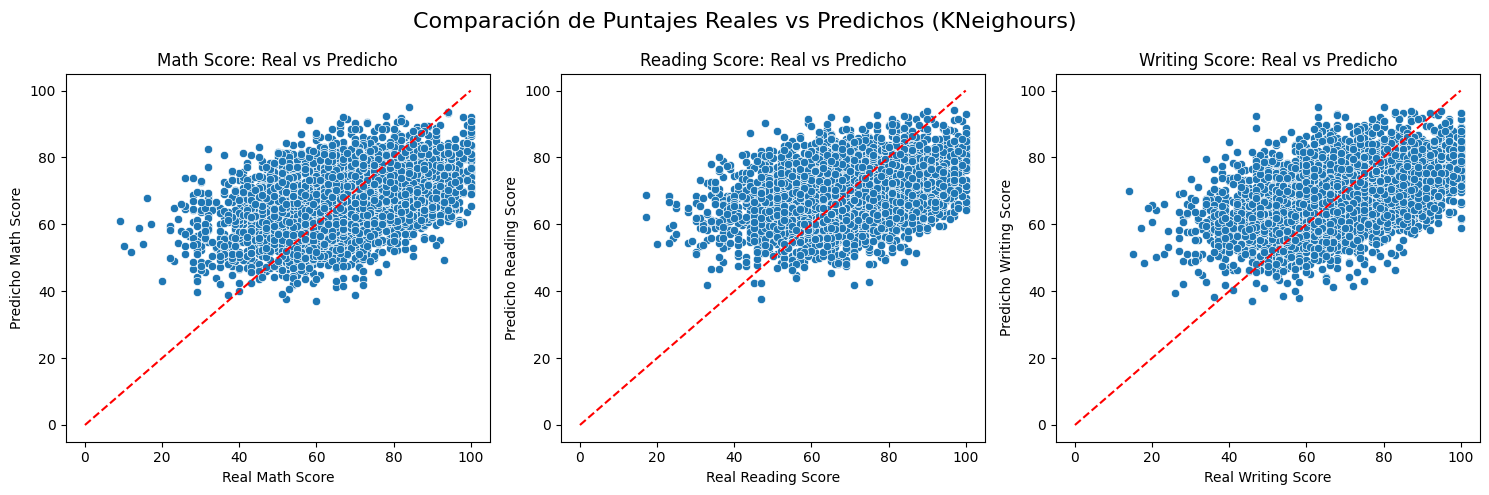

In [126]:
plt.figure(figsize=(15, 5))
plt.suptitle('Comparación de Puntajes Reales vs Predichos (KNeighours)', fontsize=16)
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test['MathScore'], y=y_pred_math)
plt.plot([0, y_test['MathScore'].max()], [0, y_test['MathScore'].max()], color='red', linestyle='--')
plt.title('Math Score: Real vs Predicho')
plt.xlabel('Real Math Score')
plt.ylabel('Predicho Math Score')
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test['ReadingScore'], y=y_pred_reading)
plt.plot([0, y_test['ReadingScore'].max()], [0, y_test['ReadingScore'].max()], color='red', linestyle='--')
plt.title('Reading Score: Real vs Predicho')
plt.xlabel('Real Reading Score')
plt.ylabel('Predicho Reading Score')
plt.subplot(1, 3, 3)
sns.scatterplot(x=y_test['WritingScore'], y=y_pred_writing)
plt.plot([0, y_test['WritingScore'].max()], [0, y_test['WritingScore'].max()], color='red', linestyle='--')
plt.title('Writing Score: Real vs Predicho')
plt.xlabel('Real Writing Score')
plt.ylabel('Predicho Writing Score')
plt.tight_layout()
plt.show()

In [109]:
pca = PCA(n_components=2)

X_test_scaled = StandardScaler().fit_transform(X_test)
X_test_pca = pca.fit_transform(X_test_scaled)

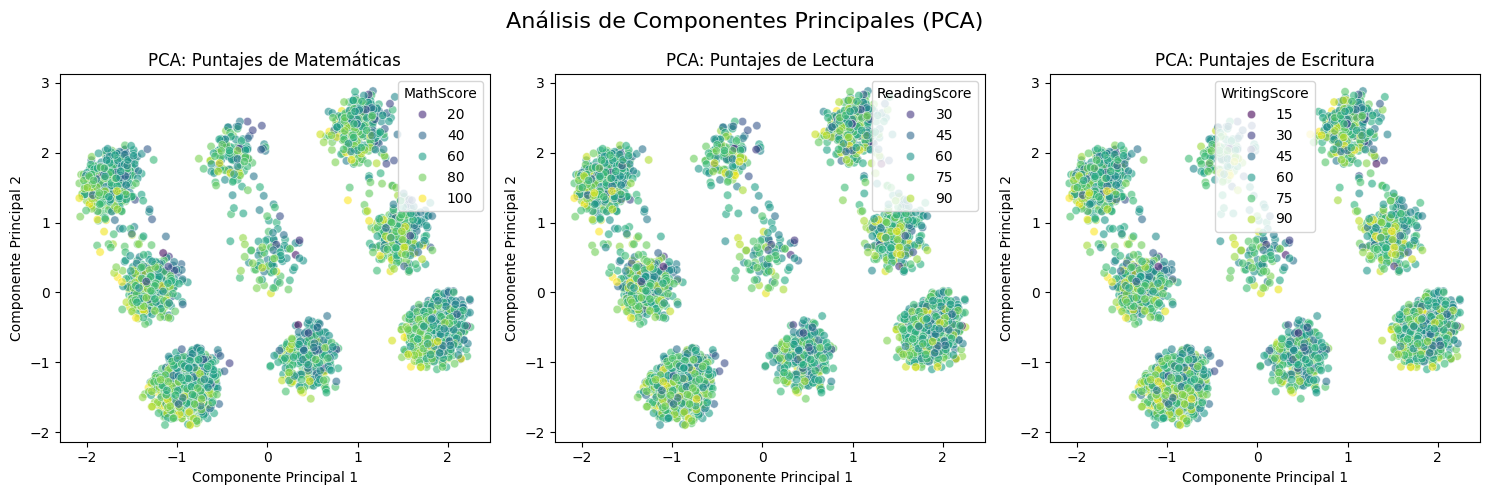

In [127]:
plt.figure(figsize=(15, 5))
plt.suptitle('Análisis de Componentes Principales (PCA)', fontsize=16)
plt.subplot(1, 3, 1)
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_test['MathScore'], palette='viridis', alpha=0.6)
plt.title('PCA: Puntajes de Matemáticas')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.subplot(1, 3, 2)
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_test['ReadingScore'], palette='viridis', alpha=0.6)
plt.title('PCA: Puntajes de Lectura')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.subplot(1, 3, 3)
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_test['WritingScore'], palette='viridis', alpha=0.6)
plt.title('PCA: Puntajes de Escritura')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.tight_layout()
plt.show()

In [128]:
print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)
print("Varianza total explicada:", np.sum(pca.explained_variance_ratio_))

Varianza explicada por cada componente: [0.08153603 0.07593198]
Varianza total explicada: 0.15746800742085845


In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_test_tsne = tsne.fit_transform(X_test_scaled)

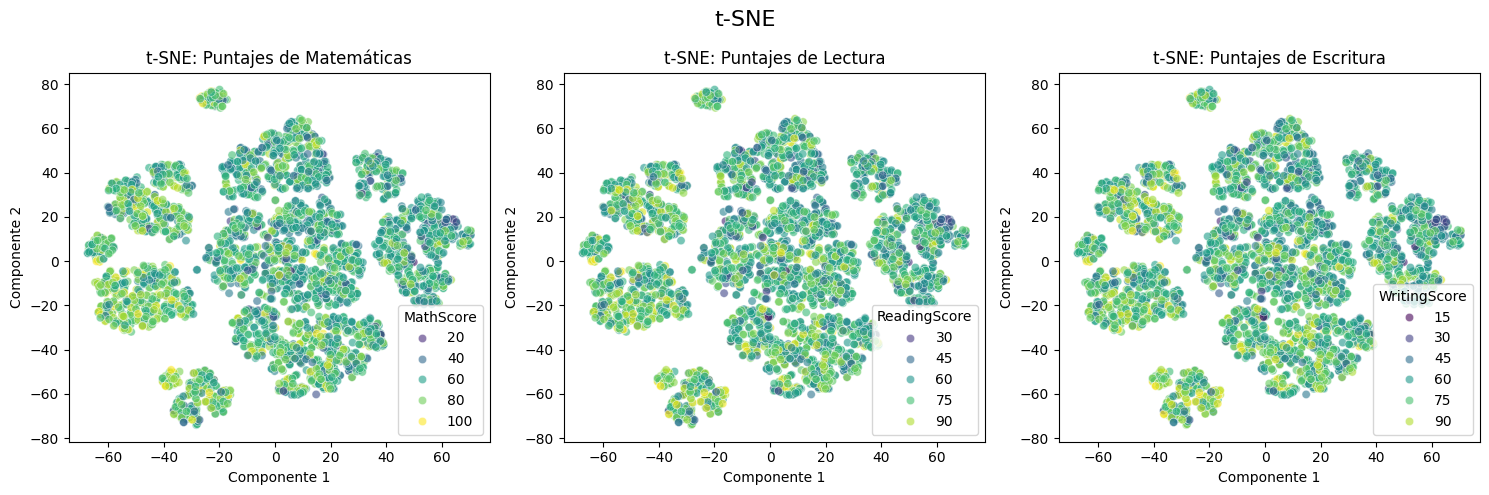

In [112]:
plt.figure(figsize=(15, 5))
plt.suptitle('t-SNE', fontsize=16)
plt.subplot(1, 3, 1)
sns.scatterplot(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], hue=y_test['MathScore'], palette='viridis', alpha=0.6)
plt.title('t-SNE: Puntajes de Matemáticas')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.subplot(1, 3, 2)
sns.scatterplot(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], hue=y_test['ReadingScore'], palette='viridis', alpha=0.6)
plt.title('t-SNE: Puntajes de Lectura')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.subplot(1, 3, 3)
sns.scatterplot(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], hue=y_test['WritingScore'], palette='viridis', alpha=0.6)
plt.title('t-SNE: Puntajes de Escritura')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.tight_layout()
plt.show()

In [115]:
umap_model = UMAP(n_components=2, random_state=42)
X_test_umap = umap_model.fit_transform(X_test_scaled)

c:\Users\cmeri\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


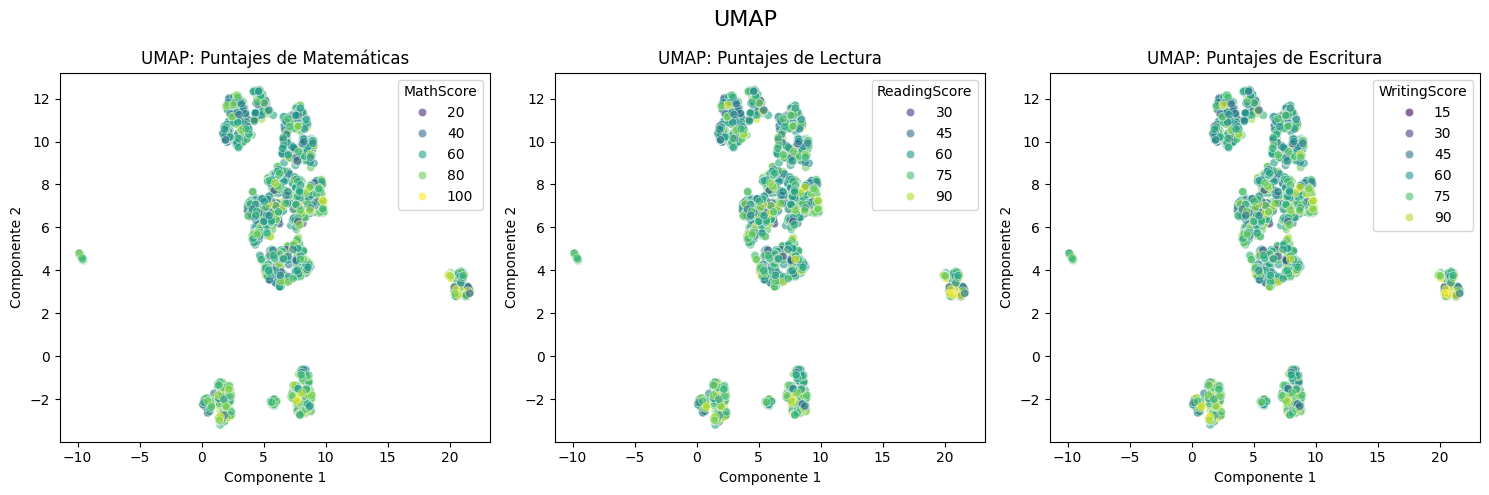

In [116]:
plt.figure(figsize=(15, 5))
plt.suptitle('UMAP', fontsize=16)
plt.subplot(1, 3, 1)
sns.scatterplot(x=X_test_umap[:, 0], y=X_test_umap[:, 1], hue=y_test['MathScore'], palette='viridis', alpha=0.6)
plt.title('UMAP: Puntajes de Matemáticas')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.subplot(1, 3, 2)
sns.scatterplot(x=X_test_umap[:, 0], y=X_test_umap[:, 1], hue=y_test['ReadingScore'], palette='viridis', alpha=0.6)
plt.title('UMAP: Puntajes de Lectura')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.subplot(1, 3, 3)
sns.scatterplot(x=X_test_umap[:, 0], y=X_test_umap[:, 1], hue=y_test['WritingScore'], palette='viridis', alpha=0.6)
plt.title('UMAP: Puntajes de Escritura')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.tight_layout()
plt.show()